# Analysis file for Ariane quantitative runs
gets data from .nc file into basic plot<br>
based on code from https://github.com/SalishSeaCast/analysis-susan/blob/master/notebooks/Ariane/FluxRobertsBankApr2015-New.ipynb

In [1]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
from dateutil.relativedelta import relativedelta

import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d

%matplotlib inline
# plt.rcParams['font.size'] = 18

### get grid info

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

# Functions

In [3]:
def draw_patches(fmask, lonW, lonE, t_dist, t_depths): #draw ground part of cross section
    topo = []
    for i in range(lonW,lonE):
        for j in range(39):
            if fmask[j, i] == 0:
                rect = Rectangle((t_dist[i], t_depths[j]), t_dist[i+1]-t_dist[i], t_depths[j+1]-t_depths[j])
                topo.append(rect)
    pc = PatchCollection(topo, facecolors='lightgray', zorder=3)
    return(pc)

In [4]:
def TracerFluxCS(mydata, tracername, section, lonW, lonE, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lon = mymesh.nav_lon[igrid]
    time = mydata.init_t[-1]
    
    lons = mydata.final_lon[(mydata.final_section==section)]
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lons = mymesh.glamt[0, igrid]
    m2lon = ((t_lons[lonE]-t_lons[lonW])/(mymesh.e1t[0, igrid, lonW:lonE].sum()))
    t_dist = t_lons/m2lon
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lons/m2lon
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section == section)]
        if tracername == 'salt':
            t_max = round(34 * 0.1,1)
            cmap = cm.haline
            units = 'g kg-1 m s-1'
        else:
            t_max = round(45 * 0.1,1)
            cmap = cm.matter
            units = 'mmol m-2 s-1'
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section == section)]
        if tracername == 'nitrate':
            t_max = round(30 * 0.1,1)
            cmap = cm.rain
            units = 'mmol m-2 s-1'
        else:
            t_max = round(2200 * 0.1,1)
            cmap = cm.turbid
            units = 'mmol m-2 s-1'
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')
               
    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[lonW-1:lonE]), t_depths],weights= transports, density= True)# vmax=vmax)

    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[lonW-1:lonE]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[lonW-1:lonE]), t_depths])
       
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)
    

    X, Y = np.meshgrid(xedges, yedges)
#     cmap = cm.haline
#     cmap.set_bad('grey', None)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, vmin = 0, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, t_max]) 
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, lonW-2, lonE, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[lonW+1], t_dist[lonE-1], 5))
    ax.set_xticklabels(np.round(np.linspace(t_lons[lonW+1], t_lons[lonE-1], 5),2))
    ax.set_xlim((t_dist[lonW-2], t_dist[lonE]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

### Function specific for Deception

In [5]:
def DtracerFluxCS(mydata, tracername, section, latS, latN, figrid, maxdepth, ax, title):
    igrid = figrid-1
    fmask = mymesh.fmask[0, :, :, igrid]
    tmask = mymesh.tmask[0]
    nav_lat = mymesh.nav_lat[igrid]
    time = mydata.init_t[-1]
    
    lats = mydata.final_lat[(mydata.final_section==section)]
    
    t_lat = mymesh.gphit[0,:,igrid]
    m2lat = ((t_lat[latN]-t_lat[latS])/(mymesh.e2t[0, latS:latN, igrid].sum()))
    t_dist = t_lat/m2lat
    t_depths = mymesh.gdept_1d[0,:]
    
    xs, ys = np.meshgrid(np.array(t_dist), np.array(t_depths))
    
    dist = lats/m2lat
    depths = depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section)]/time
    
    if tracername == 'salt' or tracername == 'silicon':
        tracer = mydata.init_salt[(mydata.final_section == section)]
        if tracername == 'salt':
            t_max = round(34 * 0.1,1)
            cmap = cm.haline
            units = 'g kg-1 m s-1'
        else:
            t_max = round(45 * 0.1,1)
            cmap = cm.matter
            units = 'mmol m-2 s-1'
    elif tracername == 'temp' or tracername == 'nitrate' or tracername == 'carbon':
        tracer = mydata.init_temp[(mydata.final_section == section)]
        if tracername == 'nitrate':
            t_max = round(30 * 0.1,1)
            cmap = cm.rain
            units = 'mmol m-2 s-1'
        else:
            t_max = round(2200 * 0.1,1)
            cmap = cm.turbid
            units = 'mmol m-2 s-1'
    else:
        print('incorrect tracer name, options are salt, temp, silicon, carbon, nitrate')

    H1, xedges1, yedges1 = np.histogram2d(dist, depths, bins=[np.array(t_dist[latS-1:latN+1]), t_depths],weights= transports, density= True)
    
    H = binned_statistic_2d(dist, depths, tracer, statistic=np.mean, bins=[np.array(t_dist[latS-1:latN+1]), t_depths])
    _, xedges, yedges = np.histogram2d(dist, depths, bins = [np.array(t_dist[latS-1:latN+1]), t_depths])
    
    H_final = H1.T * H.statistic.T * float(sum(transports))
    np.nan_to_num(H_final, nan=0, copy=False)

    X, Y = np.meshgrid(xedges, yedges)
    im = ax.pcolormesh(X, Y, H_final, vmax = t_max, cmap=cmap)
    cb1 = fig.colorbar(im, ax=ax)
    cb1.set_ticks([0, t_max])
    cb1.set_ticklabels([0, t_max])
    cb1.set_label(units, labelpad=-20)
    
    pc = draw_patches(fmask, latS-2, latN, np.array(t_dist), np.array(t_depths))
    ax.add_collection(pc)

    ax.invert_yaxis()
    ax.set_xticks(np.linspace(t_dist[latS-1], t_dist[latN], 2))
    ax.set_xticklabels(np.round(np.linspace(t_lat[latS-1], t_lat[latN], 2),2))
    ax.set_xlim((t_dist[latS-2], t_dist[latN]))
    ax.set_ylim((maxdepth, 0))
#     ax.set_title(str(title))
    mydata.close()

In [6]:
#lets make a fun lil matrix with all of the info we need about every channel to run the cross-section code
#in the format [section, jgridW, jgridE, figrid, maxdepth]
admiralty = [2, 255, 267, 204, 100]
rosario = [4, 286, 307, 266, 100]
sanjuan = [5, 264, 266, 280, 100]
haro = [6, 218, 242, 304, 300]

#in the format [section, jgridS, jgridN, figrid, maxdepth]
decep = [3, 246, 247, 309, 20]

# March
## Backwards run (source water, going from strait in title to the JDF)

In [7]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/backward_31mar19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/backward_31mar19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

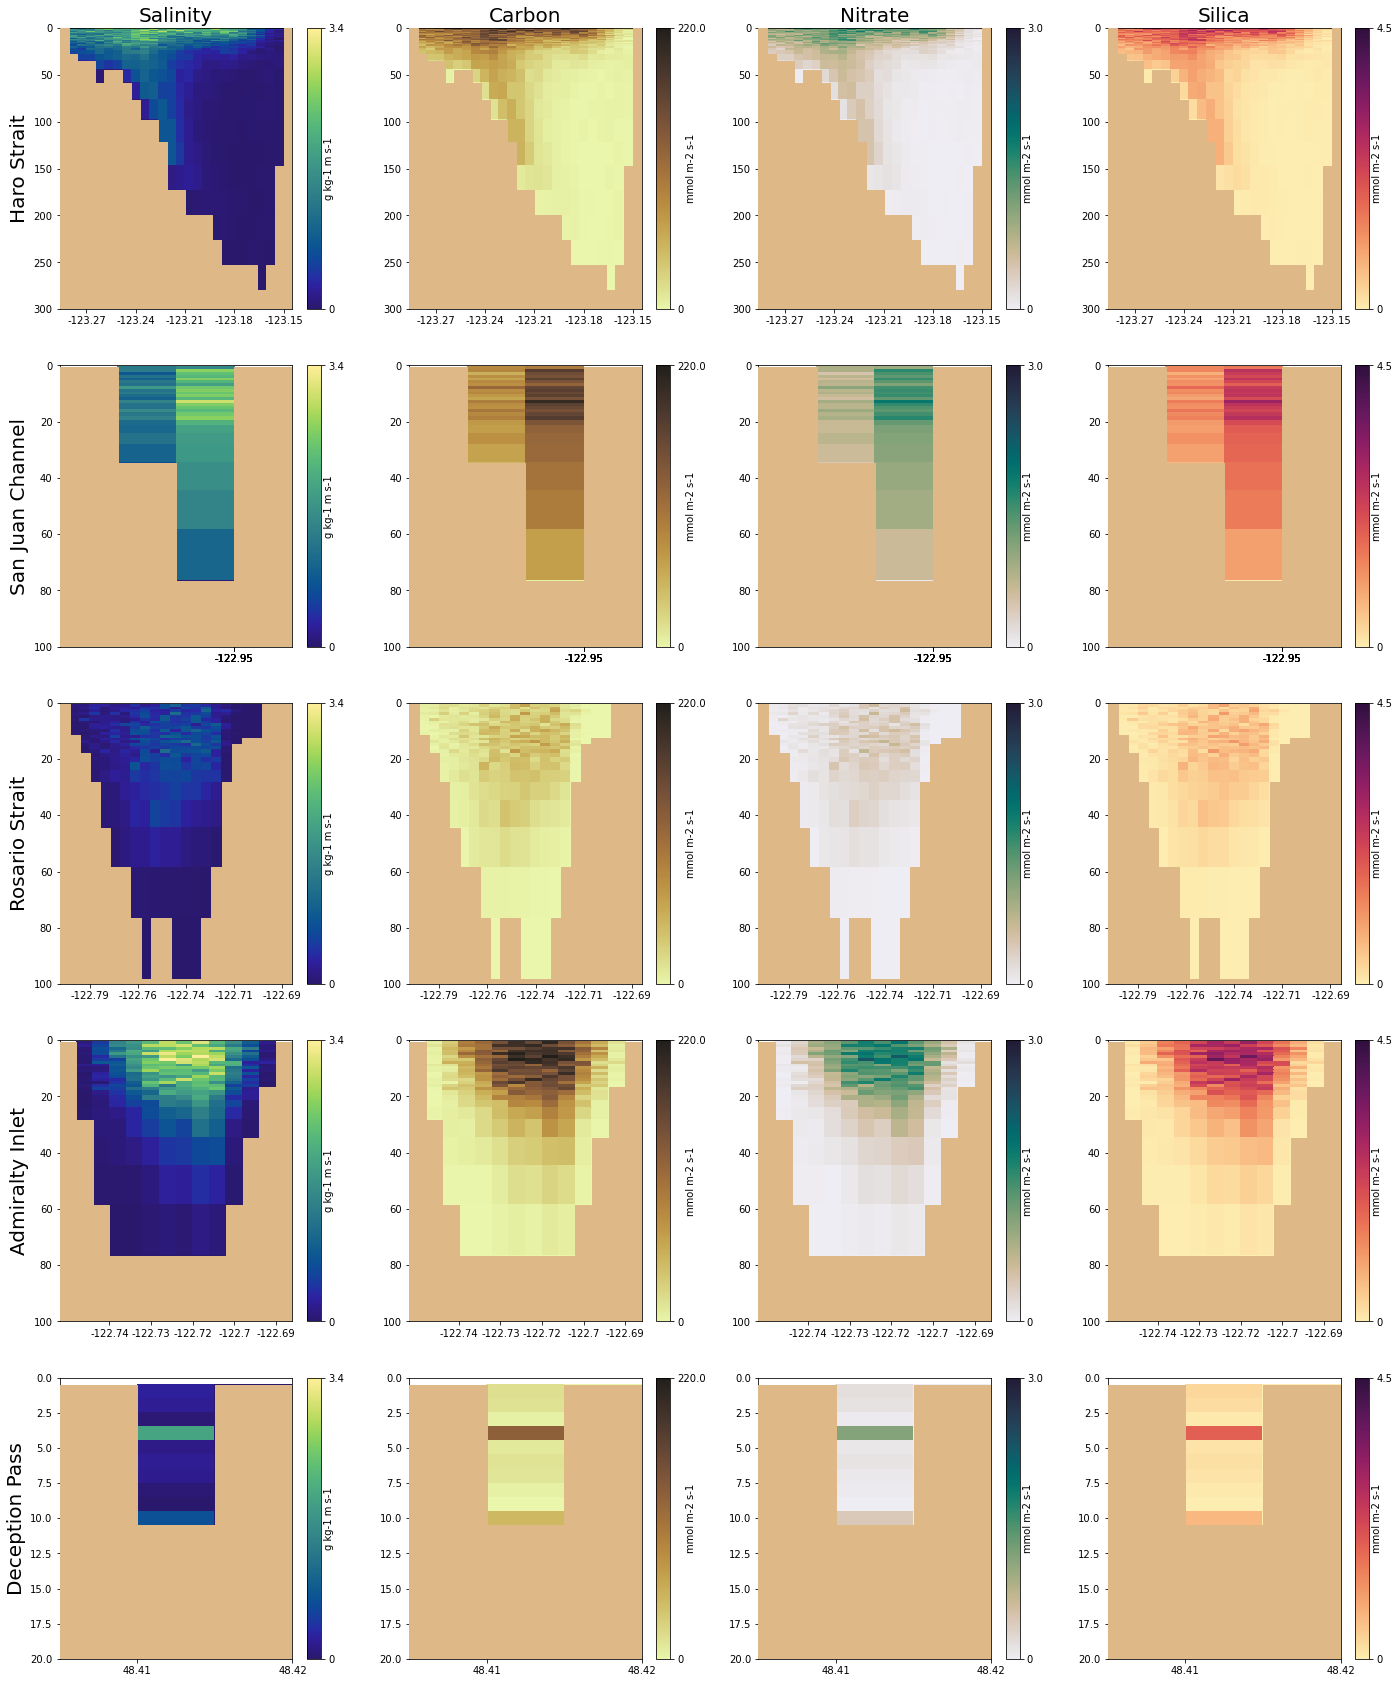

In [8]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro Out, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro Out, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan Out, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan Out, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario Out, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario Out, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty Out, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty Out, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception Out, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception Out, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception Out, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception Out, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

## Forwards run (from JDF to these straits)

In [9]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01mar19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01mar19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

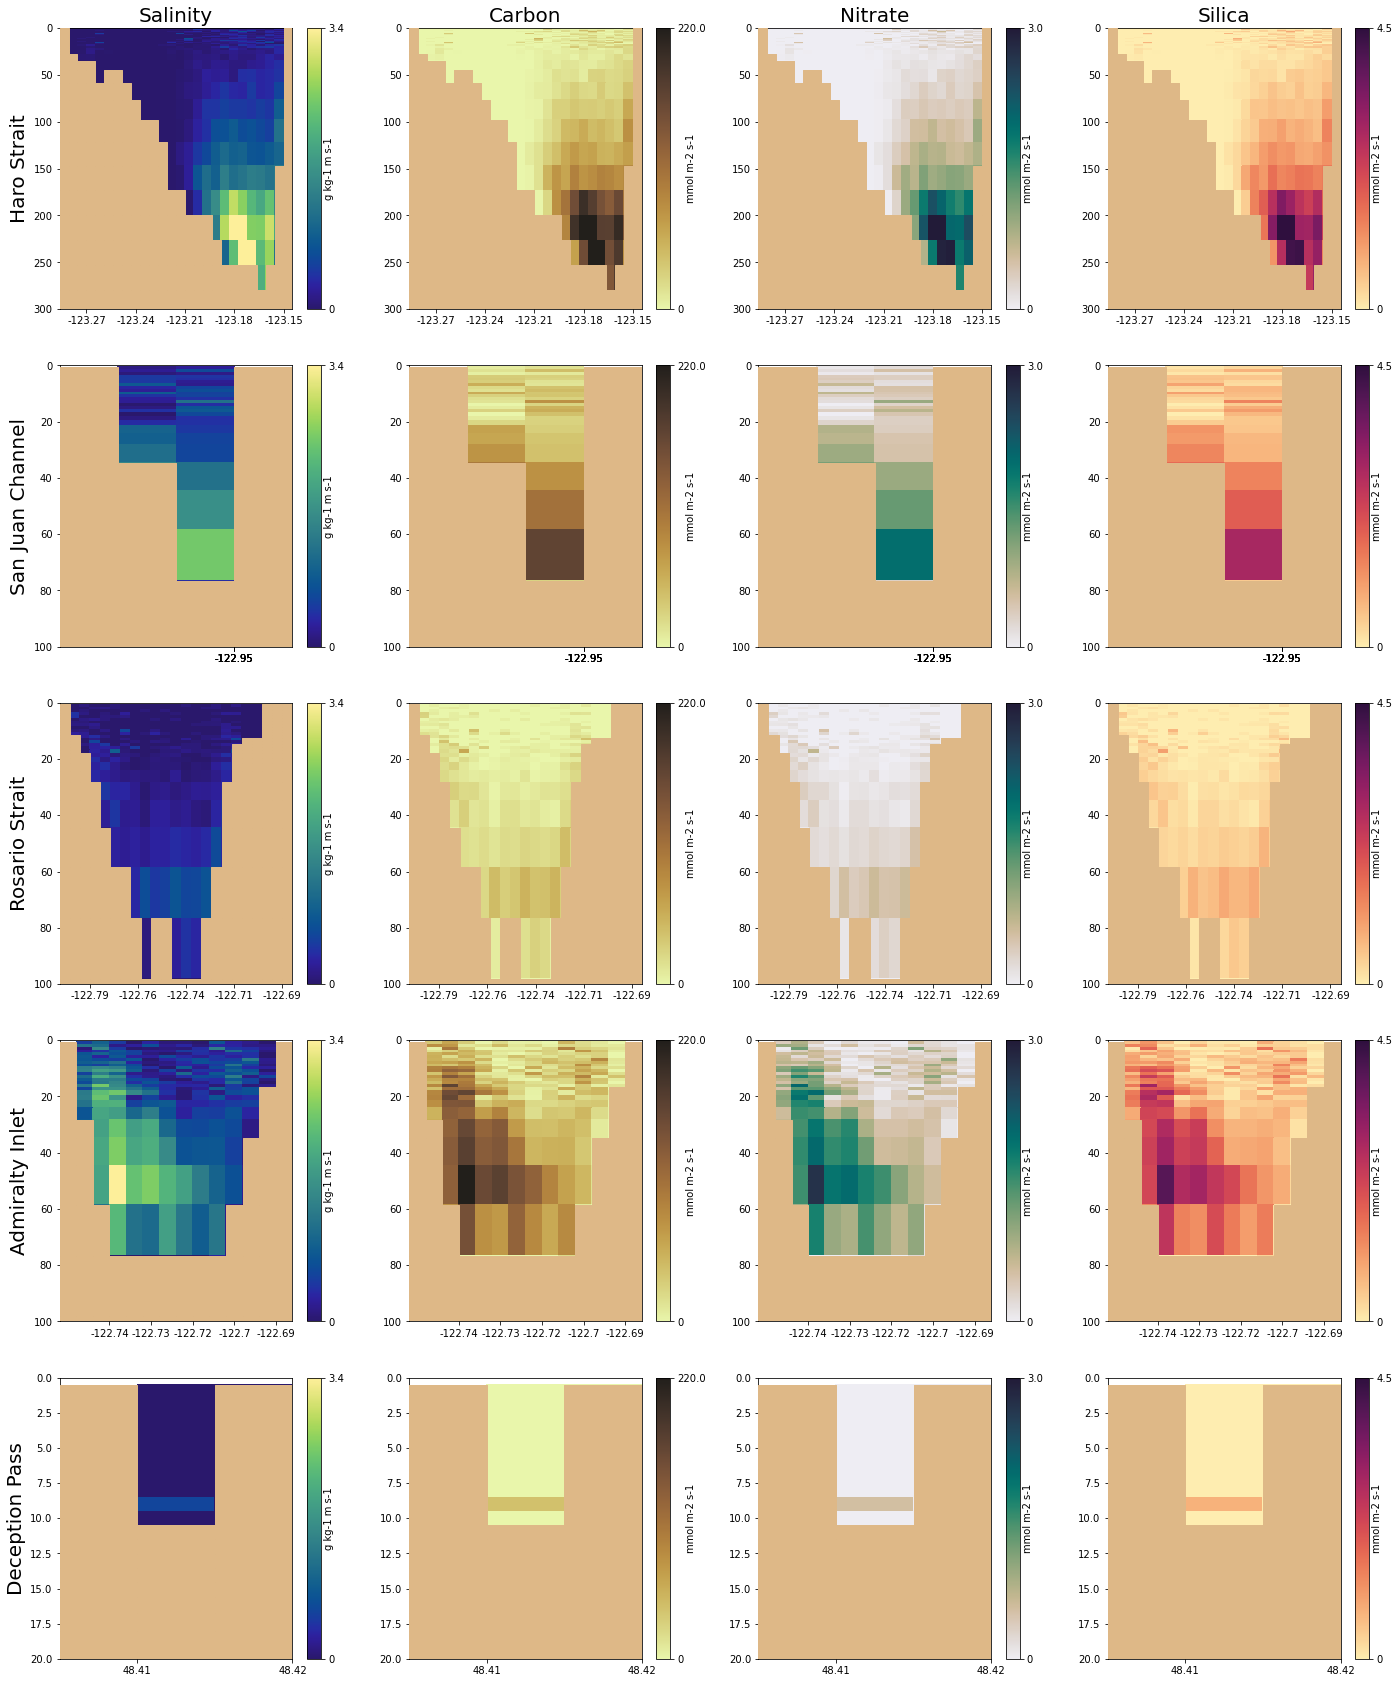

In [10]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro In, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro In, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro In, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro In, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan In, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan In, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan In, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan In, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario In, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario In, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario In, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario In, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty In, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty In, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty In, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty In, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception In, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception In, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception In, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception In, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

# June
## Backwards run (source water, going from strait in title to the JDF)

In [11]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/backward_01jul19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/backward_01jul19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

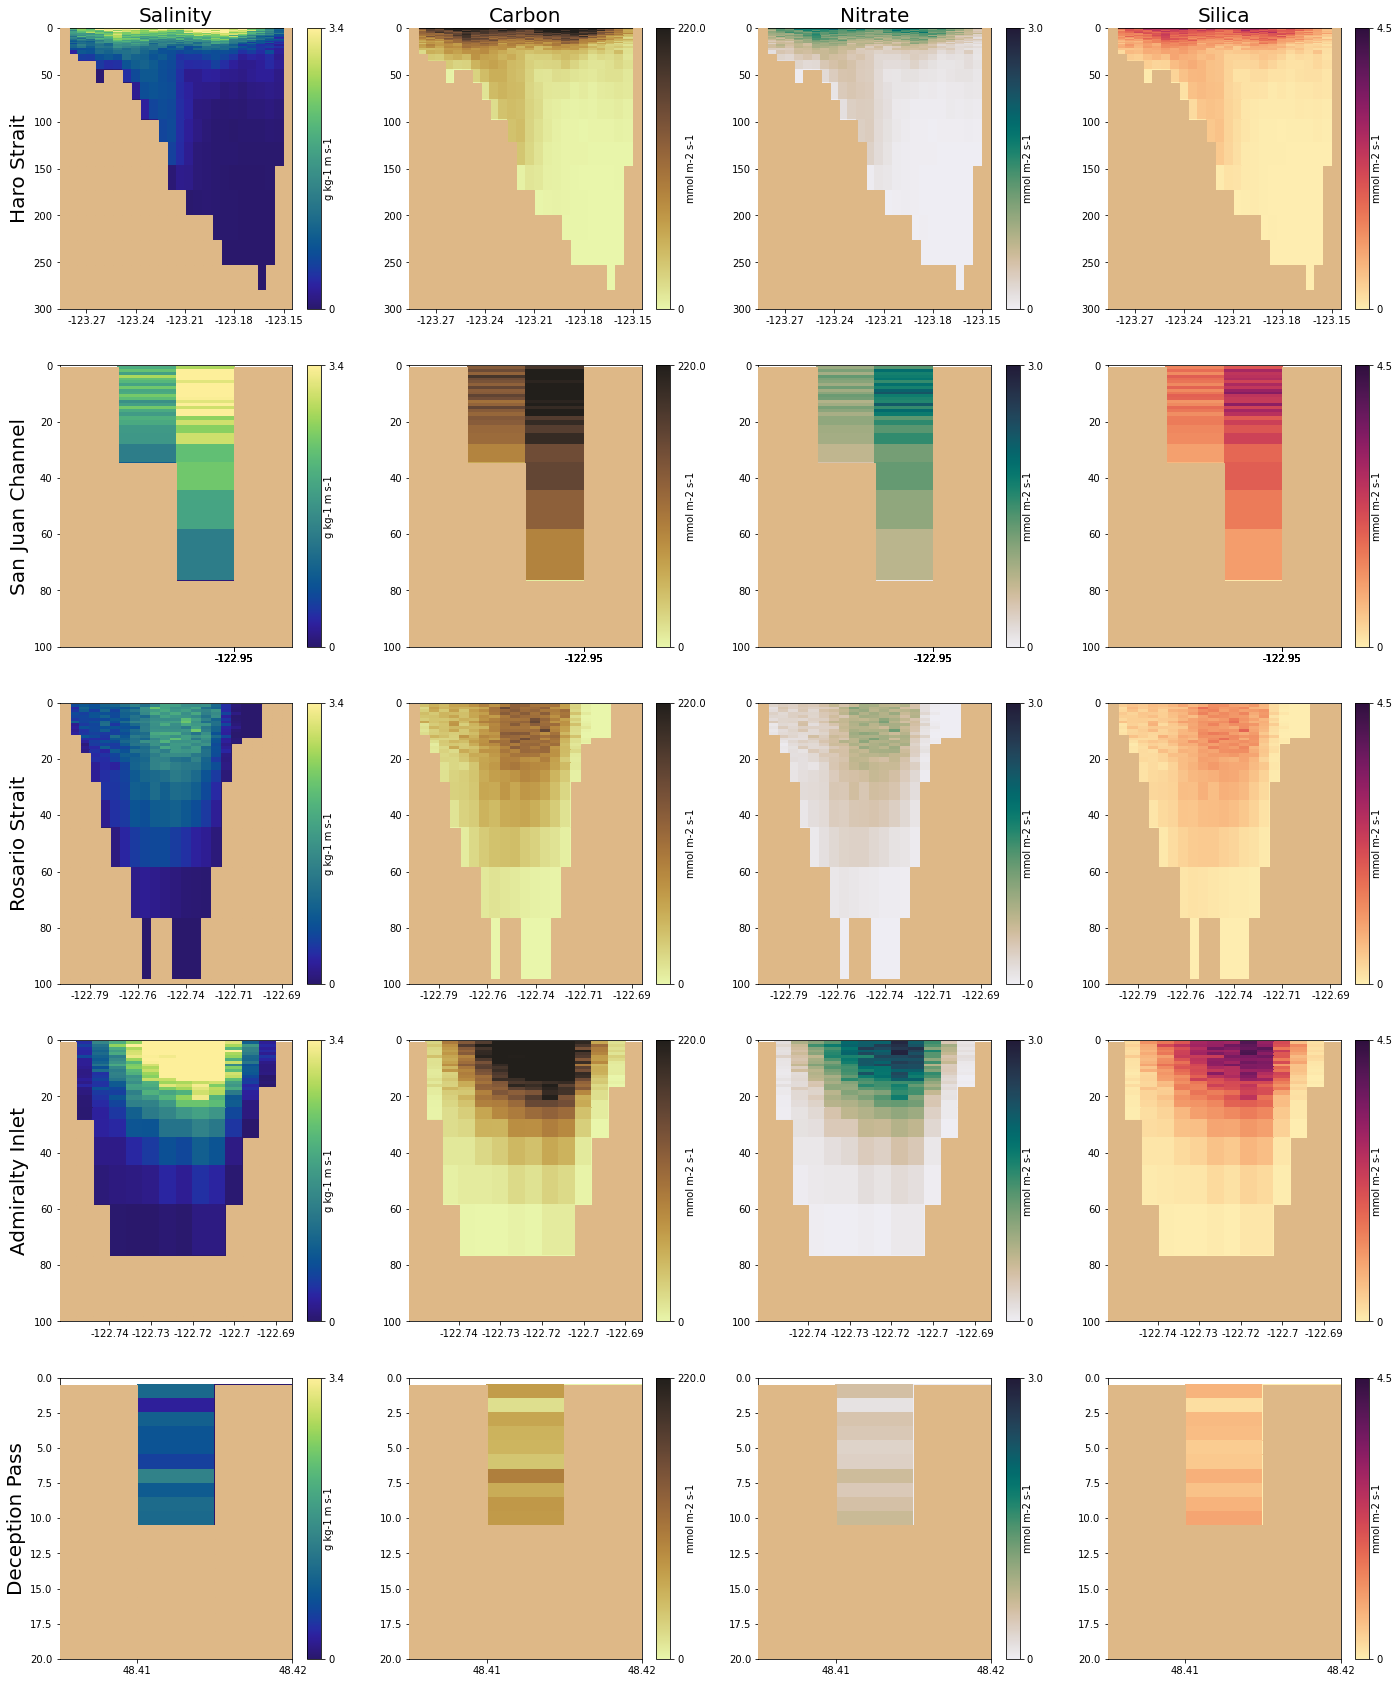

In [12]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro Out, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro Out, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan Out, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan Out, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario Out, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario Out, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty Out, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty Out, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception Out, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception Out, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception Out, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception Out, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

## Forwards run (from JDF to these straits)

In [13]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01jun19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01jun19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

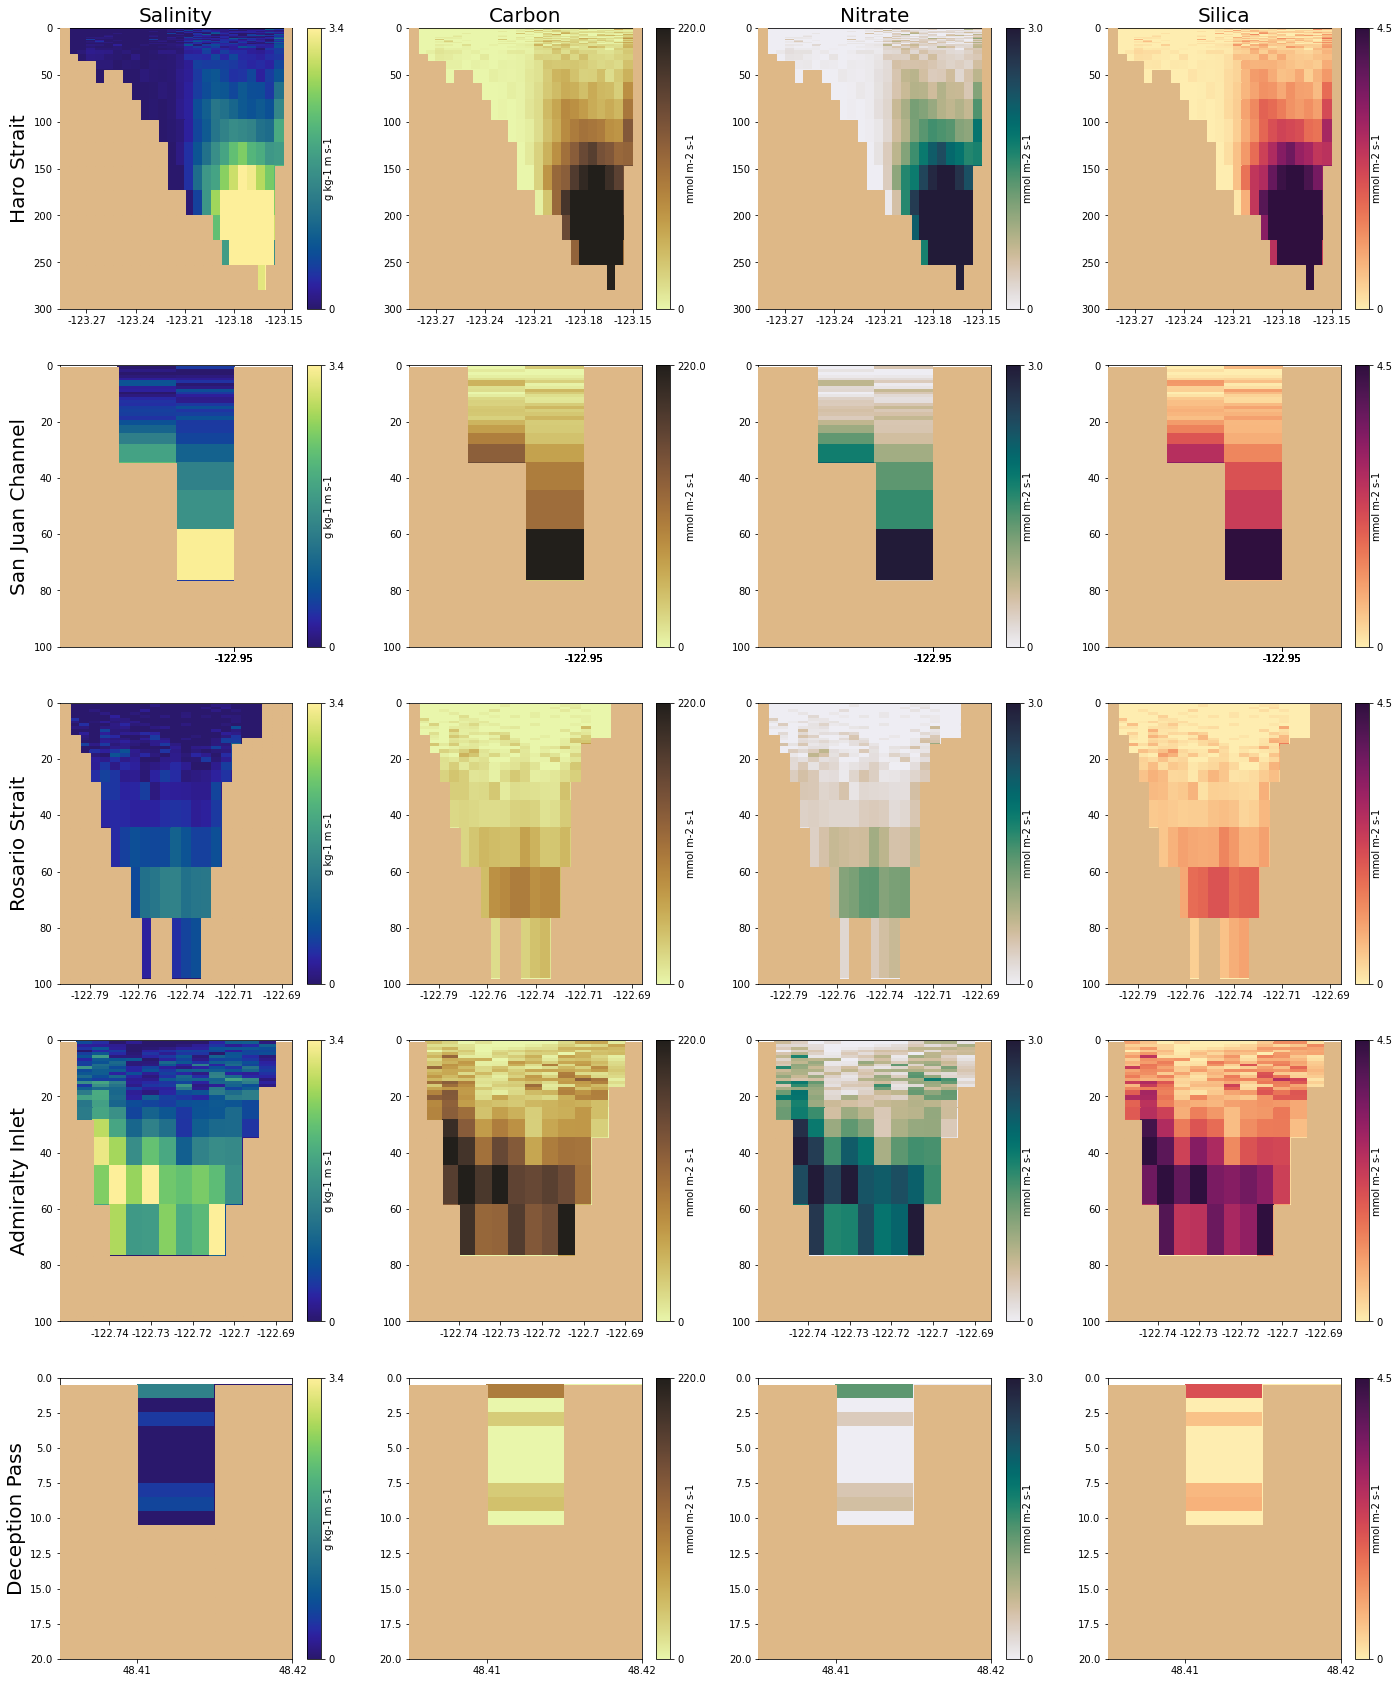

In [14]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro In, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro In, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro In, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro In, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan In, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan In, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan In, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan In, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario In, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario In, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario In, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario In, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty In, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty In, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty In, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty In, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception In, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception In, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception In, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception In, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

# September
## Backwards run (source water, going from strait in title to the JDF)

In [15]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/backward_01oct19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/backward_01oct19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

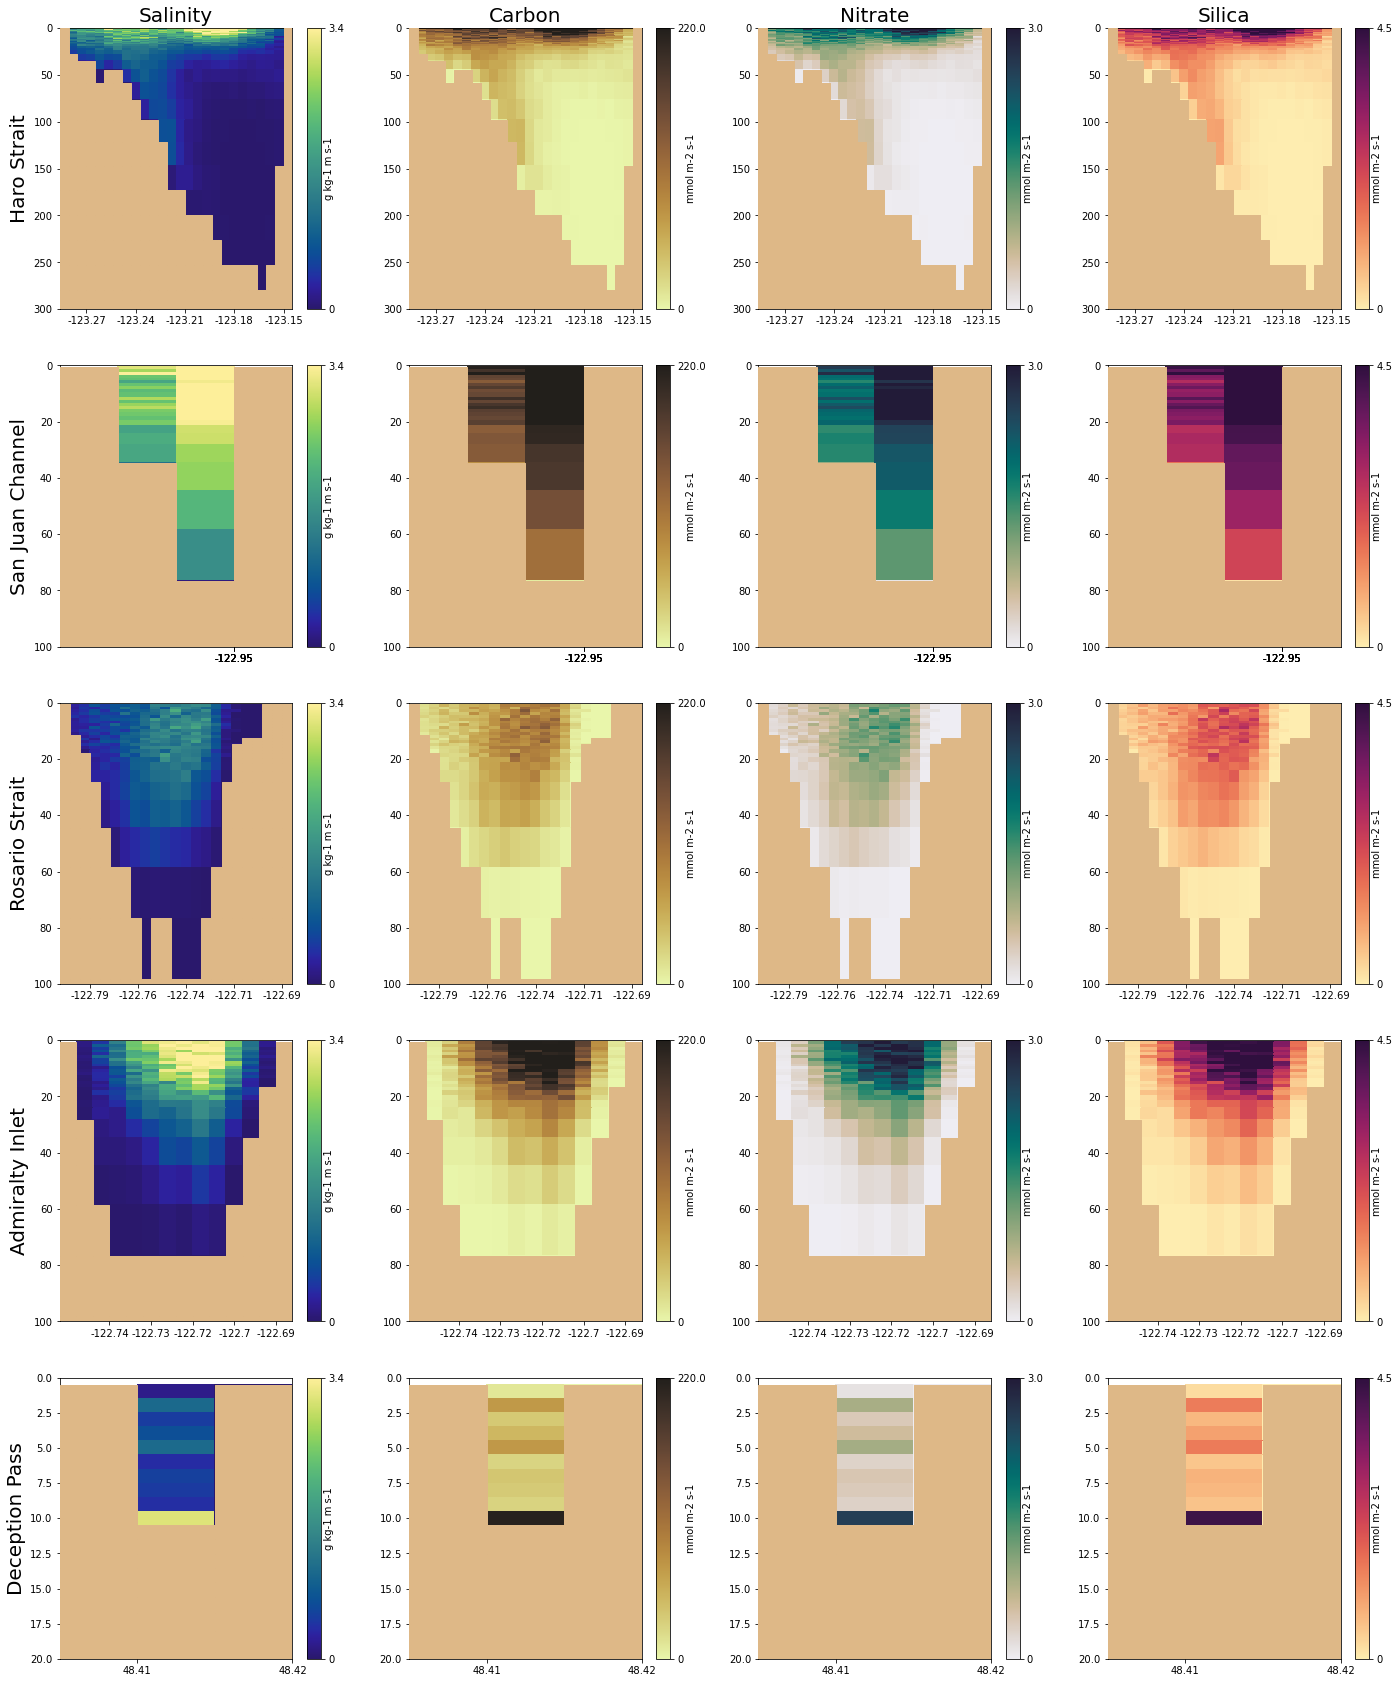

In [16]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro Out, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro Out, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan Out, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan Out, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario Out, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario Out, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty Out, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty Out, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception Out, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception Out, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception Out, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception Out, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

## Forwards run (from JDF to these straits)

In [17]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01sep19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01sep19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

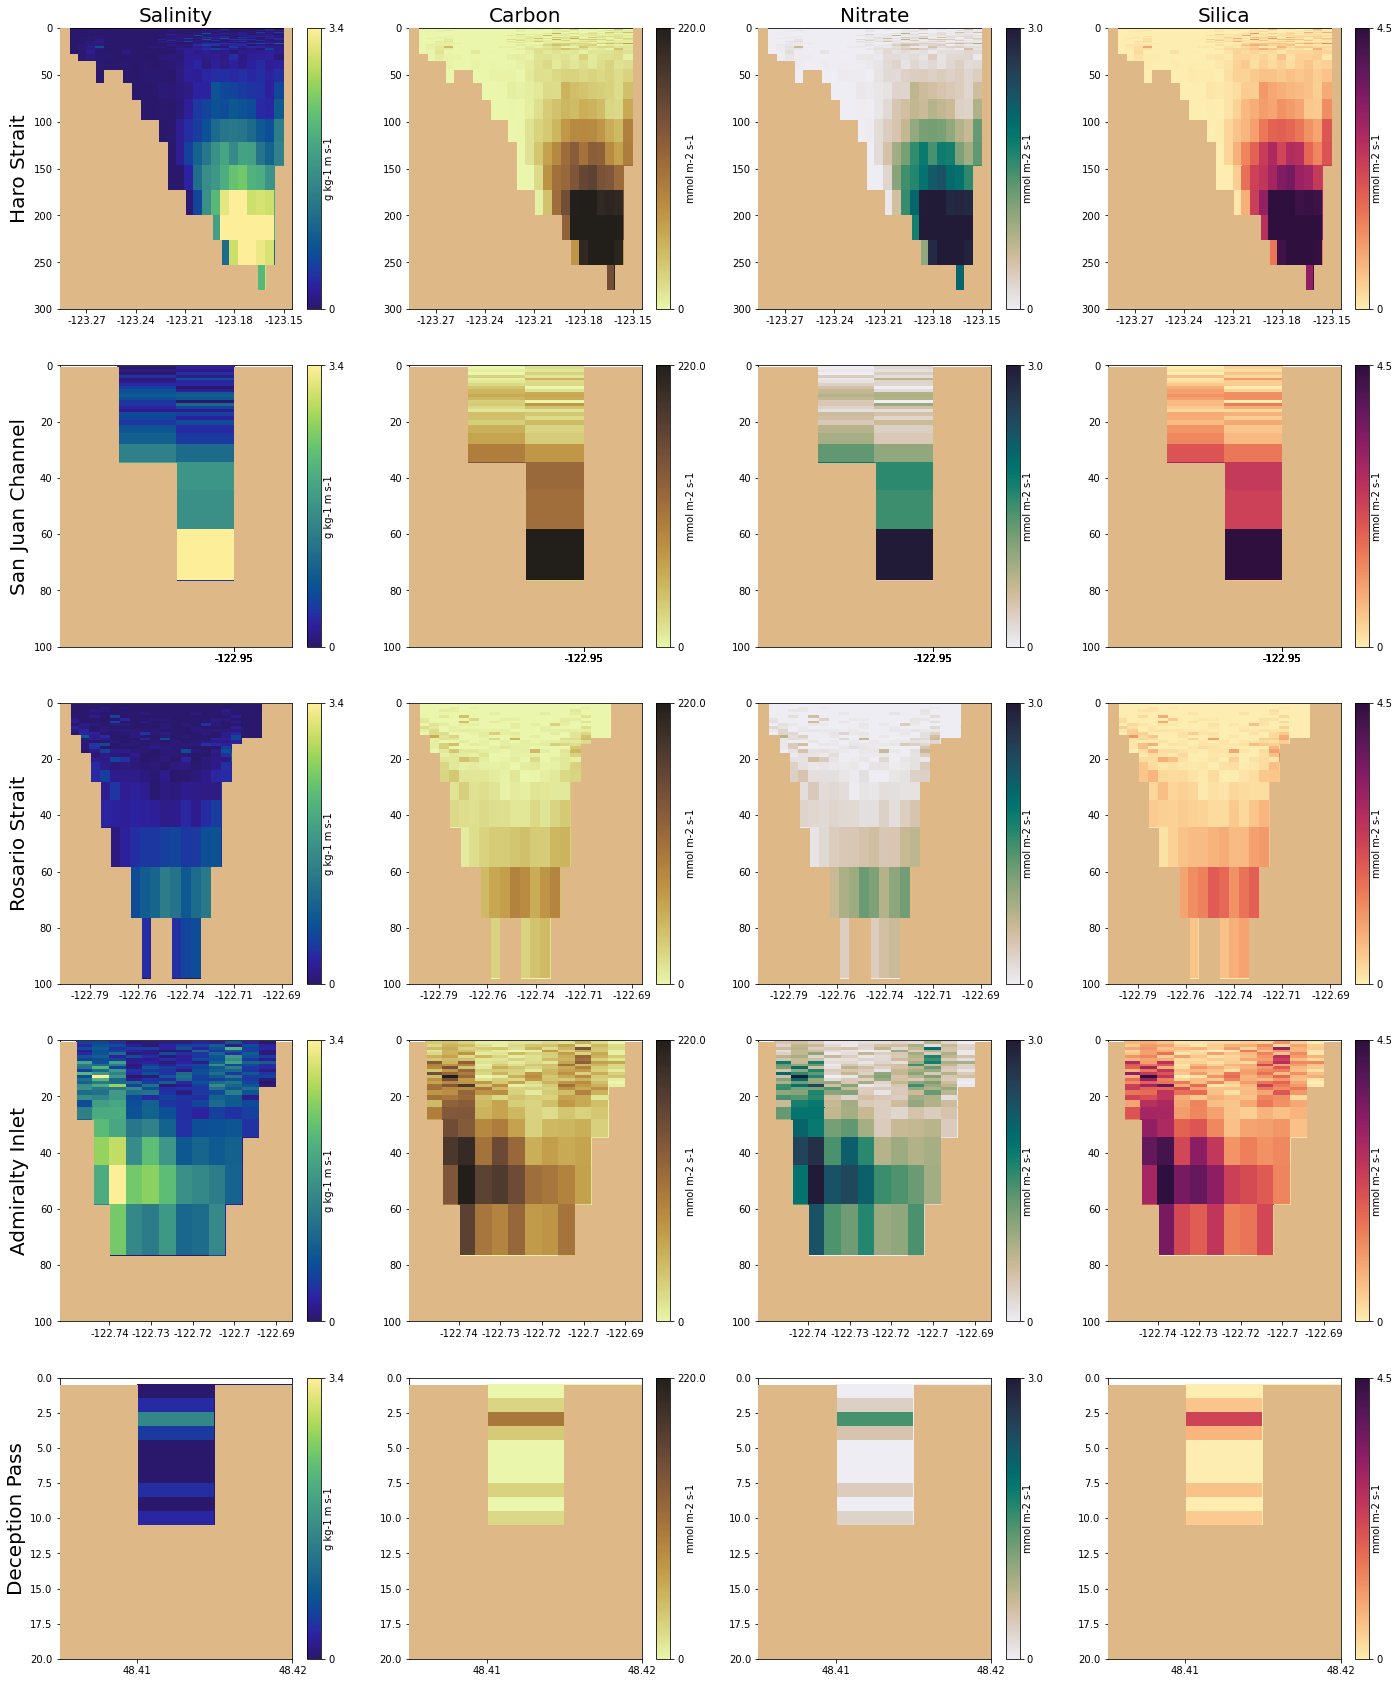

In [18]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro In, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro In, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro In, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro In, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan In, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan In, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan In, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan In, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario In, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario In, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario In, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario In, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty In, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty In, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty In, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty In, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception In, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception In, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception In, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception In, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

# December
## Backwards run (source water, going from strait in title to the JDF)

In [19]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/backward_31dec19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/backward_31dec19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

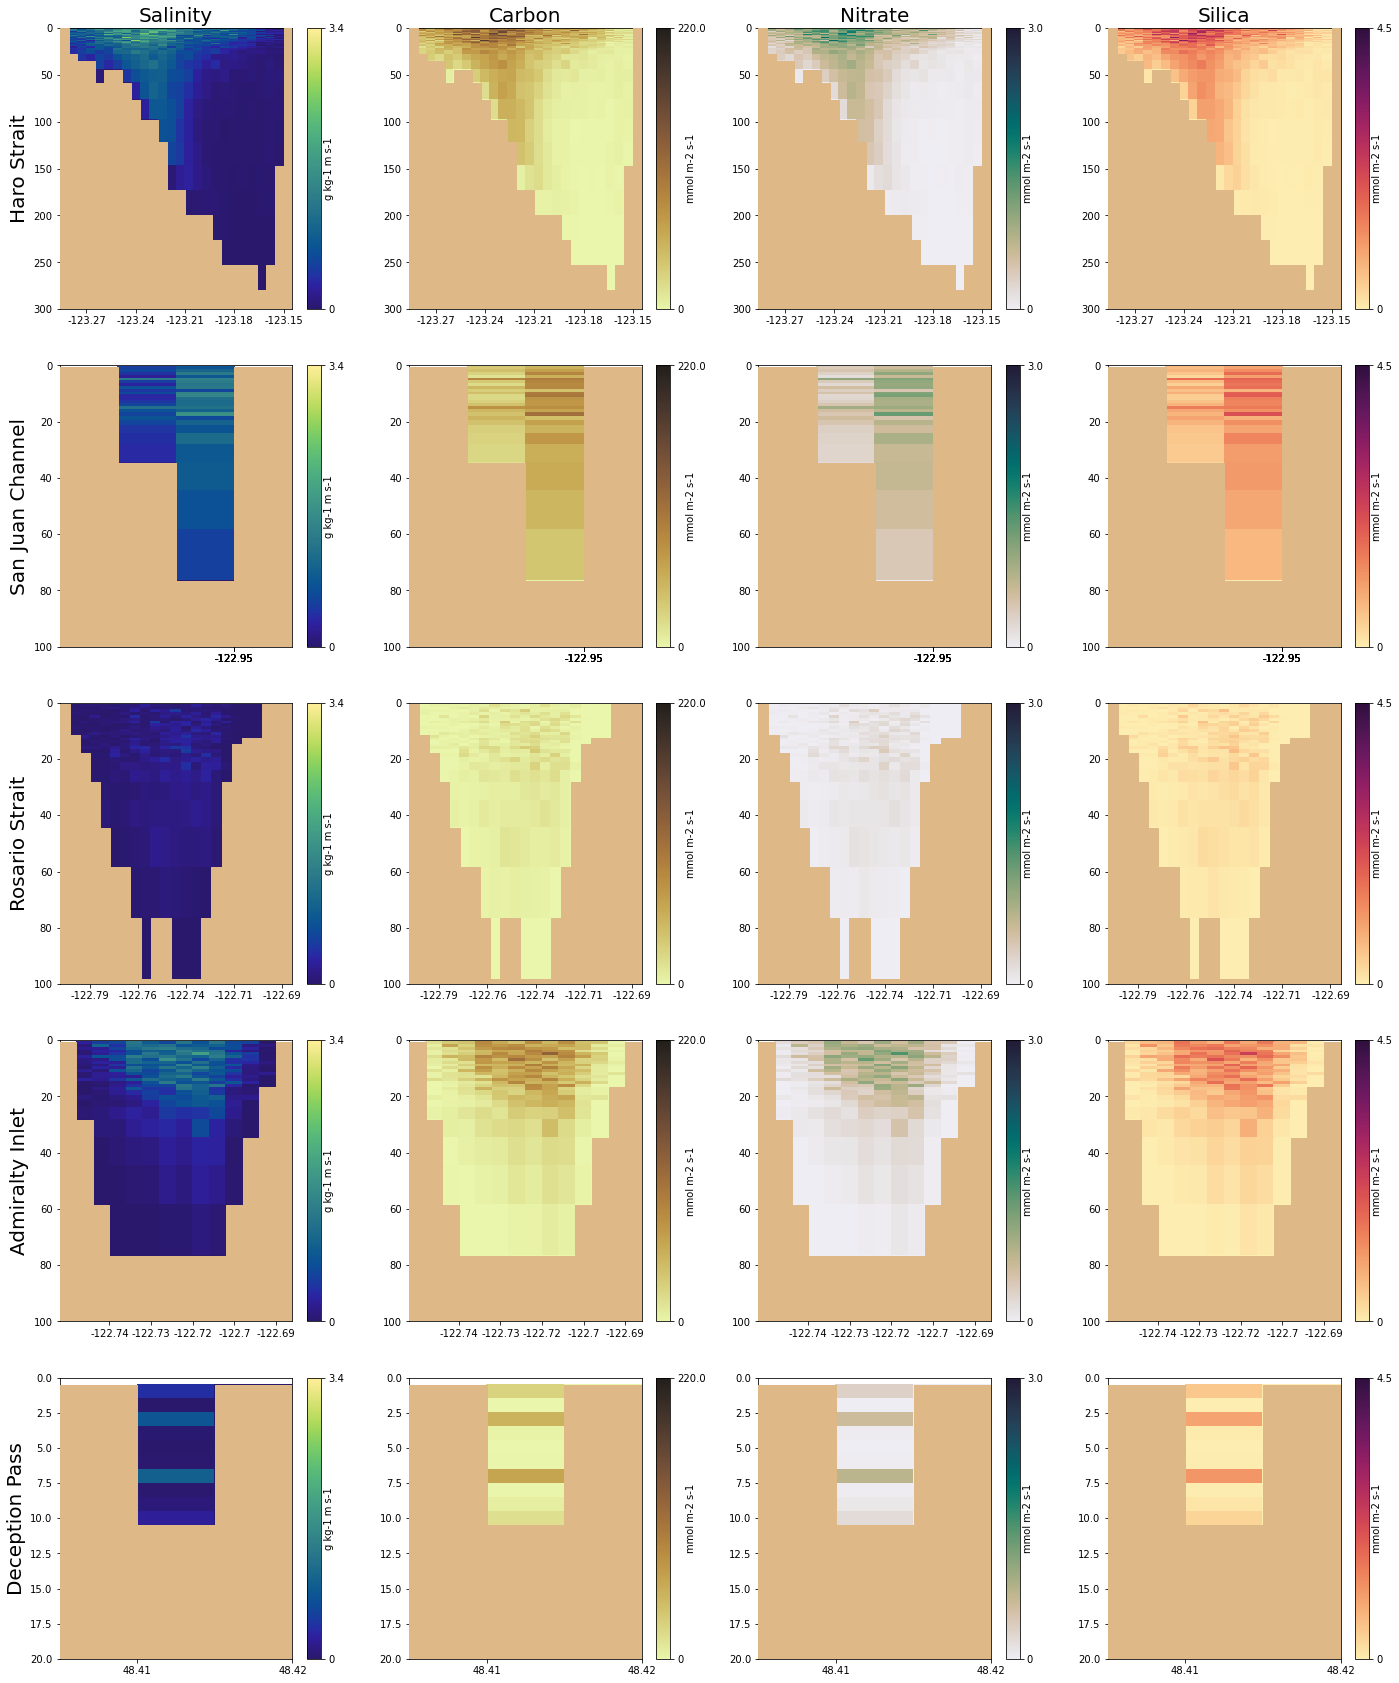

In [20]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro Out, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro Out, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan Out, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan Out, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario Out, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario Out, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty Out, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty Out, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty Out, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty Out, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception Out, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception Out, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception Out, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception Out, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

## Forwards run (from JDF to these straits)

In [21]:
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Car_Sal/forward_01dec19/ariane_positions_quantitative.nc'
file2 = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_Nit_Sil/forward_01dec19/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
mydata2 = xr.open_dataset(file2)

Text(0.5, 1.0, 'Silica')

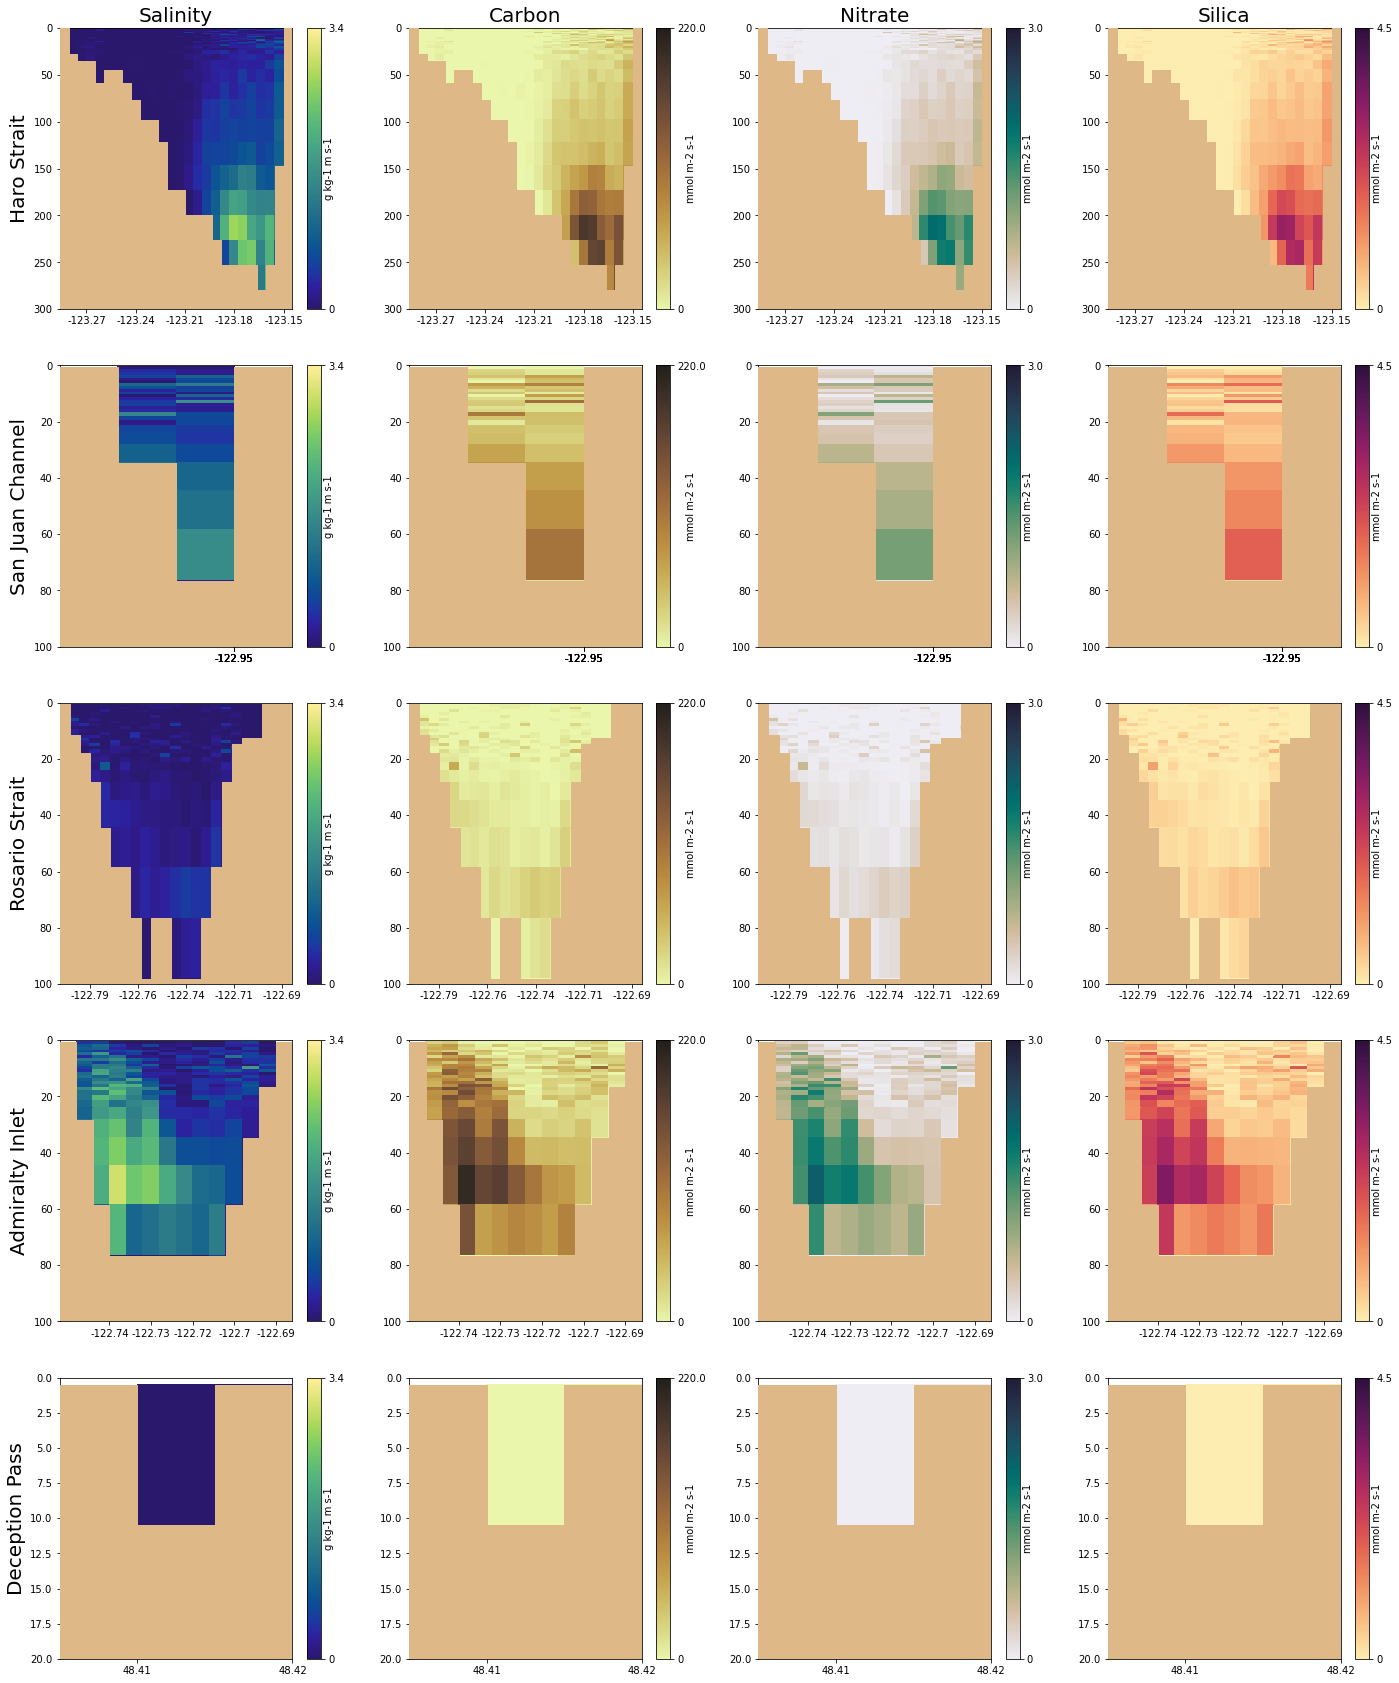

In [22]:
fig, axs = plt.subplots(5, 4, figsize = (24, 30))
TracerFluxCS(mydata, 'salt', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,0], "Haro In, Salinity")
TracerFluxCS(mydata, 'carbon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,1], "Haro In, Carbon")
TracerFluxCS(mydata2, 'nitrate', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,2], "Haro In, Nitrate")
TracerFluxCS(mydata2, 'silicon', haro[0], haro[1], haro[2], haro[3], haro[4], axs[0,3], "Haro In, Silicon")

TracerFluxCS(mydata, 'salt', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 0], "San Juan In, Salinity")
TracerFluxCS(mydata, 'carbon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 1], "San Juan In, Carbon")
TracerFluxCS(mydata2, 'nitrate', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 2], "San Juan In, Nitrate")
TracerFluxCS(mydata2, 'silicon', sanjuan[0], sanjuan[1], sanjuan[2], sanjuan[3], sanjuan[4], axs[1, 3], "San Juan In, Silicon")

TracerFluxCS(mydata, 'salt', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 0], "Rosario In, Salinity")
TracerFluxCS(mydata, 'carbon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 1], "Rosario In, Carbon")
TracerFluxCS(mydata2, 'nitrate', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 2], "Rosario In, Nitrate")
TracerFluxCS(mydata2, 'silicon', rosario[0], rosario[1], rosario[2], rosario[3], rosario[4], axs[2, 3], "Rosario In, Silicon")

TracerFluxCS(mydata, 'salt', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 0], "Admiralty In, Salinity")
TracerFluxCS(mydata, 'carbon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 1], "Admiralty In, Carbon")
TracerFluxCS(mydata2, 'nitrate', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 2], "Admiralty In, Nitrate")
TracerFluxCS(mydata2, 'silicon', admiralty[0], admiralty[1], admiralty[2], admiralty[3], admiralty[4], axs[3, 3], "Admiralty In, Silicon")

DtracerFluxCS(mydata, 'salt', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,0], "Deception In, Salinity")
DtracerFluxCS(mydata, 'carbon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,1], "Deception In, Carbon")
DtracerFluxCS(mydata2, 'nitrate', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,2], "Deception In, Nitrate")
DtracerFluxCS(mydata2, 'silicon', decep[0], decep[1], decep[2], decep[3],decep[4], axs[4,3], "Deception In, Silicon")

axs[0,0].set_ylabel('Haro Strait', fontsize = 20)
axs[1,0].set_ylabel('San Juan Channel', fontsize = 20)
axs[2,0].set_ylabel('Rosario Strait', fontsize = 20)
axs[3,0].set_ylabel('Admiralty Inlet', fontsize = 20)
axs[4,0].set_ylabel('Deception Pass', fontsize = 20)
axs[0,0].set_title('Salinity', fontsize = 20)
axs[0,1].set_title('Carbon', fontsize = 20)
axs[0,2].set_title('Nitrate', fontsize = 20)
axs[0,3].set_title('Silica', fontsize = 20)

### lets get % of flow to each CS month to month for the full 5 years

In [3]:
def get_transport(mydata, section, starttime, endtime):
    time = endtime-starttime+1
    transports = (mydata.final_transp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time
    sumTr = sum(transports)
    
    transports = (mydata.final_transp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time
    totalTr = sum(transports)
    return sumTr, totalTr

In [4]:
yearjumps = [0,1,-2,1,0,1,0,1,1,0,1,0]
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
starttime = 1
endtime = 720
time = endtime-starttime+1

sec_nums = [2,3,4,5,6]
admiralty = np.array([])
deception = np.array([])
rosario = np.array([])
sanjuan = np.array([])
haro = np.array([])
sections = [admiralty, deception, rosario, sanjuan, haro]
all_total = np.array([])

#2016 and 2017
year = [16,17]

for num in year:
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for j in range(len(sec_nums)):
            temp, totalT = get_transport(mydata, sec_nums[j], starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
            sections[j] = np.append(sections[j],temp)
        all_total = np.append(all_total, totalT)

#2019 and 2018 (both done month by month)
year = [18,19]
for num in year:
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_1hr/forward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        totalT = sum((mydata.final_transp[(mydata.final_section != 0) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time)

        for j in range(len(sec_nums)):
            temp = sum((mydata.final_transp[(mydata.final_section==sec_nums[j]) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)])/time)
            sections[j] = np.append(sections[j],temp)       
        all_total = np.append(all_total, totalT)
            
#2020
file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_1hr/forward_01jan20/ariane_positions_quantitative.nc'
mydata = xr.open_dataset(file)
for i in range(12):
    for j in range(len(sec_nums)):
        temp, totalT = get_transport(mydata, sec_nums[j], starttime+(i*720+(sum(yearjumps[:i+1]*24))), endtime+(i*720+(sum(yearjumps[:i+1]*24))))
        sections[j] = np.append(sections[j],temp)
    all_total = np.append(all_total, totalT)

In [5]:
admiralty = sections[0]
deception = sections[1]
rosario = sections[2]
sanjuan = sections[3]
haro = sections[4]

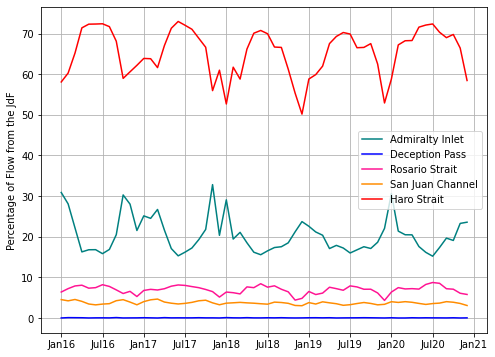

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot(admiralty/all_total*100, c='teal',label="Admiralty Inlet")
ax.plot(deception/all_total*100, c='b',label="Deception Pass")
ax.plot(rosario/all_total*100, c='deeppink',label="Rosario Strait")
ax.plot(sanjuan/all_total*100, c='darkorange', label="San Juan Channel")
ax.plot(haro/all_total*100, c='r',label="Haro Strait")
ax.legend()
ax.set_ylabel("Percentage of Flow from the JdF")
# ax.set_xlabel("Month")
ax.set_xticks(np.arange(0,61,6))
ax.set_xticklabels(['Jan16','Jul16','Jan17','Jul17','Jan18','Jul18','Jan19','Jul19','Jan20','Jul20','Jan21'])
ax.grid()

In [8]:
print("haro average = "+str(sum(haro)/len(haro)))
print("rosario average = "+str(sum(rosario)/len(rosario)))
print("sanjuan average = "+str(sum(sanjuan)/len(sanjuan)))

print("admiralty average = "+str(sum(admiralty)/len(admiralty)))
print("deception average = "+str(sum(deception)/len(deception)))

print('SoG average = '+str((sum(haro)+sum(rosario)+sum(sanjuan))/len(haro)))
print('Puget average = '+str((sum(admiralty)+sum(deception))/len(haro)))

haro average = 47043.53629694011
rosario average = 5059.256530137992
sanjuan average = 2621.0124974082623
admiralty average = 13583.884002511168
deception average = 53.380141421131825
SoG average = 54723.80532448636
Puget average = 13637.2641439323


In [9]:
# (sum(haro[12:24])+sum(rosario[12:24])+sum(deception[12:24]))/12
print('SoG 2017 average = '+str((sum(haro[12:24])+sum(rosario[12:24])+sum(sanjuan[12:24]))/12))
print('Puget 2017 average = '+str((sum(admiralty[12:24])+sum(deception[12:24]))/12))

SoG 2017 average = 55788.09422595443
Puget 2017 average = 14265.766659171655


In [7]:
haro

array([21607.62935578, 30937.59524706, 28608.17327696, 49721.44876697,
       66819.99343723, 66302.99103956, 70196.42032056, 79090.53886138,
       61630.66308424, 21341.85400949, 16339.42762823, 35184.51990547,
       35331.51596407, 38619.53594129, 25406.74443193, 32898.6926534 ,
       58357.75431197, 68158.18796724, 77729.01432585, 71613.22684731,
       58785.61575529, 47916.5094692 , 19427.86803411, 39905.75970759,
       15650.87234754, 50255.08326631, 29717.4233556 , 36838.9611538 ,
       57870.34664285, 63706.62063013, 71878.01084082, 66604.31005884,
       50008.67309795, 42510.0442919 , 27515.29536726, 21034.9305333 ,
       25988.11579935, 44439.64786478, 36475.45953552, 42677.69863715,
       56830.41150181, 65567.50342235, 64231.84484938, 65599.82631522,
       50008.67309795, 53832.0337157 , 53301.70628165, 28271.86374852,
       20319.08534126, 43231.51673003, 44866.69420934, 52445.89368077,
       39813.96476777, 62963.94500828, 73108.37180078, 71666.02085979,
      

In [10]:
(rosario)

array([2387.49001419, 3723.87093994, 3472.68064629, 5640.11049156,
       6807.56596248, 6872.25352587, 7967.65460469, 8599.73088947,
       6285.33223482, 2191.05539624, 1776.22311846, 3006.79684648,
       3766.01825372, 4285.18182254, 2852.9682546 , 3549.09303616,
       6431.16426147, 7620.59676903, 8682.99016318, 7819.18595309,
       6395.03484339, 5068.86092417, 2263.6926743 , 3386.19902361,
       1905.53013932, 5092.24171374, 3009.69090995, 4275.9750624 ,
       6188.67974919, 7618.84281853, 7823.45364221, 7938.24349568,
       5332.71196608, 4488.74163837, 2202.23597604, 2038.25780753,
       2896.50653355, 4304.20389664, 3622.19543851, 4802.90323273,
       5945.20031901, 6396.92990689, 7292.74848314, 7568.94118679,
       5332.71196608, 5670.00964682, 5279.01424832, 2327.6755515 ,
       2215.21495635, 4825.58948974, 4720.84857417, 5570.38186868,
       3972.11206194, 7234.25998413, 8853.32941008, 8726.12800025,
       5925.51630387, 5446.33832881, 3248.68500762, 2611.59184

In [13]:
HR = np.array(haro)+np.array(rosario)+np.array(sanjuan)

In [14]:
HR

array([25689.39939365, 36844.91100371, 34093.11954682, 58232.68955965,
       76836.37256331, 76165.24248805, 81511.83302528, 91612.61835142,
       71793.16581451, 25176.53559366, 19180.40129272, 40045.92777005,
       41343.03544212, 45631.43654991, 30192.28255858, 38388.29733113,
       67792.98658048, 79028.33150307, 90326.7649718 , 83338.19530142,
       68822.99624243, 56156.12148201, 22995.8686358 , 45440.81411272,
       18649.18782522, 58416.95851786, 34684.50341697, 43204.63023617,
       67088.94619439, 74512.42990656, 83224.71734446, 78474.79127285,
       58226.23297974, 49527.07038057, 31265.34759773, 24351.84316615,
       30571.27926998, 51316.59410885, 42457.27781173, 49858.13048918,
       65681.2009394 , 74908.67263439, 74560.34428822, 76710.33828706,
       58226.23297974, 62380.74804275, 61368.5594016 , 32413.33161383,
       23928.14632653, 50542.28786336, 52249.46526033, 61009.18737177,
       45798.64174814, 73142.33769887, 85580.6702885 , 84155.41232484,
      

In [15]:
# overall summer average
#april:sep, may:oct, mar:sep, apr:nov, mar:oct
#3:9, 4+12:10+12, 2+12*2:9+12*2, 3*12*3:11+12*3, 2+12*4:10*12*4 
num_mo = 30
HR = np.array(haro)+np.array(rosario)+np.array(sanjuan)
print(np.sum([np.sum(HR[3:9]),np.sum(HR[4+12:10+12]),np.sum(HR[2+12*2:9+12*2]),np.sum(HR[3*12*3:11+12*3]),np.sum(HR[2+12*4:10*12*4])])/num_mo)

PS = np.array(admiralty)+np.array(sanjuan)
print(np.sum([np.sum(PS[3:9]),np.sum(PS[4+12:10+12]),np.sum(PS[2+12*2:9+12*2]),np.sum(PS[3*12*3:11+12*3]),np.sum(PS[2+12*4:10*12*4])])/num_mo)

64709.0912898056
17183.659252539073


In [11]:
months=np.array([pd.to_datetime(pd.to_datetime('2016-1-1') + relativedelta(months=i)) for i in range(60)])

In [10]:
season = [pd.to_datetime('2016-04-01'), pd.to_datetime('2016-09-01'),
 pd.to_datetime('2017-05-01'),pd.to_datetime('2017-10-01'),
 pd.to_datetime('2018-03-01'),pd.to_datetime('2018-09-01'),
 pd.to_datetime('2019-04-01'),pd.to_datetime('2019-11-01'),
 pd.to_datetime('2020-03-01'),pd.to_datetime('2020-10-01')]

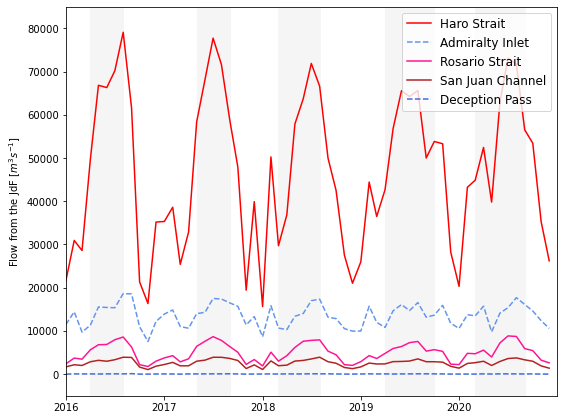

In [12]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

plt.rcParams['font.size'] = 12

ax.plot(months,haro, c='r', label="Haro Strait")
ax.plot(months,admiralty, c='cornflowerblue',label="Admiralty Inlet",linestyle='dashed')
ax.plot(months,rosario, c='deeppink',label="Rosario Strait")
ax.plot(months,sanjuan, c='firebrick', label="San Juan Channel")
ax.plot(months,deception, c='royalblue',label="Deception Pass",linestyle='dashed')

ax.legend(loc="upper right",fontsize=12)
ax.set_ylabel("Flow from the JdF [$m^{3}s^{-1}$]")
ax.set_xticks(np.array([pd.to_datetime(pd.to_datetime('2016-1-1') + relativedelta(months=i*12)) for i in range(6)]))
ax.set_xticklabels(['2016','2017','2018','2019','2020','2021'])#,fontsize=14)
ax.set_ylim(-5000,85000)
ax.set_xlim(pd.to_datetime('2016-01-01'),pd.to_datetime('2020-12-31'))

# season = np.array([pd.to_datetime(pd.to_datetime('2016-04-01') + relativedelta(months=6*i)) for i in range(10)])
for i in range(0, len(season),2):
    ax.fill_between(months, -5000, 85000, where=(months<season[i+1])&(months>=season[i]), color='whitesmoke')
plt.tight_layout()
plt.savefig("./figures/channelFlow.pdf")

In [6]:
print(np.max(rosario))
print(np.max(sanjuan))
print(np.max(deception))

8853.32941008445
3932.237718326156
126.11675874224515


In [28]:
# residence time of SoG and Puget based on volume of these basins?
V_pug = 168*(1000**3) # km3 converted to m3, easily found online
V_sog = 222000*28000*155 #couldn't find quickly nad decided not to bother, based on average width, length, and depth from Thomson 1981

(-1.0, 61.0)

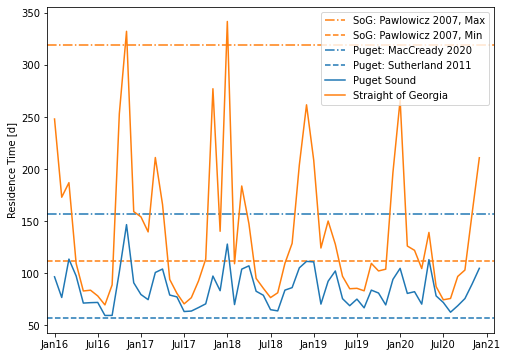

In [29]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))
ax.plot([-1,61],[319,319], c='tab:orange',  linestyle='-.',label="SoG: Pawlowicz 2007, Max")
ax.plot([-1,61],[112,112], c='tab:orange', linestyle='--',label="SoG: Pawlowicz 2007, Min")
ax.plot([-1,61],[157,157], c='tab:blue', linestyle='-.',label="Puget: MacCready 2020")
ax.plot([-1,61],[57,57], c='tab:blue', linestyle='--',label="Puget: Sutherland 2011")
ax.plot((V_pug/(admiralty+deception))/(60*60*42), c='tab:blue',label="Puget Sound")
ax.plot((V_sog/(haro+sanjuan+rosario))/(60*60*42), c='tab:orange',label="Straight of Georgia")
ax.legend()
ax.set_ylabel("Residence Time [d]")
# ax.set_xlabel("Month")
ax.set_xticks(np.arange(0,61,6))
ax.set_xticklabels(['Jan16','Jul16','Jan17','Jul17','Jan18','Jul18','Jan19','Jul19','Jan20','Jul20','Jan21'])
# ax.grid()
ax.set_xlim([-1,61])

not wild compared to previous estiamtions of the residence time of the SoG (112-319 in Pawlowicz 2007) or Puget (57 in Sutherland 2011 and 157 in MacCready 2020)